In [1]:
import os
import os.path
import numpy as np
import s3fs
import netCDF4
import xarray as xr
import matplotlib.pyplot as plt
from shapely import geometry
import fiona
from fiona.crs import from_string

In [2]:
# Adjust the variable inputs to create the prefix for the file of interest
bucket_name = 'noaa-goes16' # Change to 'noaa-goes17' for GOES-17 satellite
product_name = 'ABI-L2-LSTC'# See 'https://docs.opendata.aws/noaa-goes16/cics-readme.html' for other GOES-R products
# The following products do not use the ABI fixed grid and will not work with this script:
# Derived Motion Winds, Hurricane Intensity, Downward Shortwave Radiation, and Reflected Shortwave Radiation products
year = 2020 
day_of_year = 5 
hour = 16

# Adjust pathname to local directory
directory = "/Users/daniellelosos/GOESforGIS/"

# Adjust the number of contour intervals 
intervals = 20

In [3]:
# Make new directories to store files
if not os.path.isdir(directory + product_name +"_netCDFs"):
    os.mkdir(directory + product_name +"_netCDFs")
if not os.path.isdir(directory + product_name +"_shapefiles"):
    os.mkdir(directory + product_name +"_shapefiles") 

In [4]:
fs = s3fs.S3FileSystem(anon=True)

# Use anonymous credentials to access public data  from AWS
fs = s3fs.S3FileSystem(anon=True)

# Write prefix for the files of interest, and list all files beginning with this prefix.
prefix = f'{bucket_name}/{product_name}/{year}/{day_of_year:03.0f}/{hour:02.0f}/'
print(prefix)
files = fs.ls(prefix)

noaa-goes16/ABI-L2-LSTC/2020/005/16/


In [5]:
#Read the first netCDF file in the list (closest to the top of the hour) and download
first_file = files[0]
path = directory + product_name +"_netCDFs/" + first_file.split("/")[-1]
fs.download(first_file, path)

[None]

In [6]:
f = netCDF4.Dataset(path)

# Choose the first variable/subdataset in the netCDF file to convert to a GeoTIFF.
# To select altnative variable stored in the file, adjust the list number, ie. [0] selects the 1st variable 
var = list(f.variables.keys())[0] 
print ("Selected variable: " + var)

# Uncomment the line below to reveal the list of variables stored in the file
#print(list(f.variables.keys()))

Selected variable: LST


In [7]:
# Open dataset and parse variable information
ds = xr.open_dataset(path)
var_name = ds[var].long_name
units_name = ds[var].units
sat_h = ds['goes_imager_projection'].perspective_point_height

# The projection x and y coordinates equals the scanning angle (in radians) multiplied by the satellite height
# See details here: https://proj4.org/operations/projections/geos.html?highlight=geostationary
x = ds['x'][:] * sat_h
y = ds['y'][:] * sat_h

In [8]:
# Open netCDF file with rasterio
netCDF_file = xr.open_rasterio('netcdf:{0}:{1}'.format(path, var))

# Parse GOES-R geostationary coordinate reference system (crs)
goesR_projection = netCDF_file.crs
goesRcrs = from_string(goesR_projection)
print (goesRcrs)

{'proj': 'geos', 'lon_0': -75, 'h': 35786023, 'x_0': 0, 'y_0': 0, 'ellps': 'GRS80', 'units': 'm', 'no_defs': 'True'}


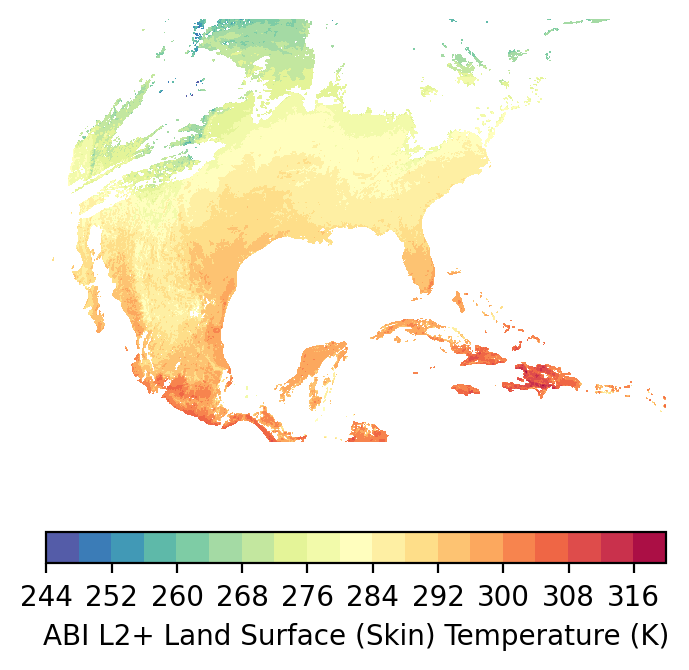

In [9]:
# Plot the variable to check if data loaded correctly
variable = ds[var].data
fig = plt.figure(figsize=(4,4),dpi=200)
matrixX, matrixY = np.meshgrid(x, y)
contours = plt.contourf(matrixX, matrixY, variable, intervals, cmap = 'Spectral_r', origin = 'upper')

# Add a colobar and axis label
plt.colorbar(label = var_name + ' ('+ units_name +')', orientation = 'horizontal')
plt.axis('off')
plt.show()

In [10]:
# Create lookup table for contour intervals
lvl_lookup = dict(zip(contours.collections, contours.levels))

In [11]:
# Define a polygon feature geometry with one attribute
shp_name = directory + product_name + "_shapefiles/" + var + str(intervals) +"intervals.shp"
structure = {
    'geometry': 'Polygon',
    'properties': {var: 'int'}}

In [12]:
# This may take several minutes. The computation time will vary in proportion to the number of intervals.

# Write a new shapefile with the GOES-R projection
with fiona.open(shp_name, 'w', crs = goesRcrs, driver='ESRI Shapefile', schema = structure) as shapefile:
    
    ## Loop through each contour ring, converting each to a polygon, and writing each to the shapefile
    for i, collection in enumerate(contours.collections):
        z = lvl_lookup[collection] # get the variable value(z) of this contour interval
        for path in collection.get_paths():
            if path.to_polygons():
                for npoly, polypoints in enumerate(path.to_polygons()):
                    poly_lons = polypoints[:, 0]
                    poly_lats = polypoints[:, 1]
                    # the ABI fixed grid coordinate system expects lon first, lat second
                    poly_init = geometry.Polygon([coords for coords in \
                                         zip(poly_lons, poly_lats)])
                    if poly_init.is_valid:
                        poly_clean = poly_init
                    else:
                        poly_clean = poly_init.buffer(0.)
                    if npoly == 0:
                        poly = poly_clean
                    else:
                        poly = poly.difference(poly_clean)
                        
            # Set the polygon to a shapefile geometry, and assign the z-value to the attribute
            shapefile.write({
            'geometry': geometry.mapping(poly),
            'properties': {var: z}})
            
print(shp_name + " has been generated")

/Users/daniellelosos/GOESforGIS/ABI-L2-LSTC_shapefiles/LST20intervals.shp has been generated
